<a href="https://colab.research.google.com/github/JoaoxCorreia/Dados-IA-Trabalhos/blob/main/PLN_Classificador_buscape_data_analysis_bag_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Buscape Data Analysis

In [ ]:
import pandas as pd

avaliacoes = pd.read_csv("b2w.csv")

In [ ]:
dataset = pd.read_csv('/kaggle/input/ptbr-sentiment-analysis-datasets/buscape.csv')
dataset.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/ptbr-sentiment-analysis-datasets/buscape.csv'

Because the goal of this notebook is study, I'm going to removing pre-processing fields to do it for myself.

In [ ]:
dataset.drop(
    columns = [
        "original_index",
        "review_text_processed",
        "review_text_tokenized",
        "kfold_polarity",
        "kfold_rating",
    ],
    inplace = True
)
dataset

,review_text,polarity,rating
0,"Estou muito satisfeito, o visor é melhor do qu...",1.0,4
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1.0,5
2,"Rápida, ótima qualidade de impressão e fácil d...",1.0,5
3,Produto de ótima qualidade em todos os quesito!,1.0,5
4,Precisava comprar uma tv compatível com meu dv...,1.0,5
...,...,...,...
84986,"Produto muito bom, simples e barato",1.0,5
84987,O esquema antigo de desmontagem e limpeza das ...,NaN,3
84988,Esse jogo é muito maneiro é um jogo onde vc te...,1.0,5
84989,Muito bom e intuitivo!\n\nO que gostei: Educa ...,NaN,3


## Data Cleaning

In [ ]:
print(f'Dataset has {dataset.shape[0]} rows x {dataset.shape[1]} columns')

Dataset has 84991 rows x 3 columns


### Checking NaN data

In [ ]:
dataset.isna().sum()

review_text        1
polarity       11364
rating             0
dtype: int64

In [ ]:
dataset.query("polarity.isna()")["rating"].unique()

array([3])

Apparently **all data that has value NaN to field "Polarity" are relative to rating 3**, which could be interpreted as **neutral sentiment**. To a first analysis, **I'll remove this "neutral" data**. To keep this information, I'll generate field "polarity_label". Removing **"review_text" data which value is NaN**, because they are **useless to NLP**:

In [ ]:
dataset.dropna(inplace = True)
dataset["polarity_label"] = dataset["polarity"].map({0.0: 'negative', 1.0: 'positive'})
dataset

,review_text,polarity,rating,polarity_label
0,"Estou muito satisfeito, o visor é melhor do qu...",1.0,4,positive
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",1.0,5,positive
2,"Rápida, ótima qualidade de impressão e fácil d...",1.0,5,positive
3,Produto de ótima qualidade em todos os quesito!,1.0,5,positive
4,Precisava comprar uma tv compatível com meu dv...,1.0,5,positive
...,...,...,...,...
84984,Excelente custo-benefício apresentado por este...,1.0,5,positive
84985,"Game muito legal, com uma grande variedade de ...",1.0,5,positive
84986,"Produto muito bom, simples e barato",1.0,5,positive
84988,Esse jogo é muito maneiro é um jogo onde vc te...,1.0,5,positive


## Checking proportion

In [ ]:
dataset.query("polarity_label == 'positive'").shape[0]

66816

In [ ]:
dataset.query("polarity_label == 'negative'").shape[0]

6810

There are several positive reviews in comparison to negative reviews. I'll treat it removing positive data until it be equal positive data.

In [ ]:
positive_partial = dataset.query("polarity_label == 'positive'").sample(6810)
negative_total = dataset.query("polarity_label == 'negative'")
dataset = pd.concat([positive_partial, negative_total])
dataset.shape

(13620, 4)

# Exploratory Data Analysis

In [ ]:
%matplotlib inline
from wordcloud import WordCloud

In [ ]:
def generate_wordcloud(dataframe: pd.DataFrame, text_column: str):
    all_words = ' '.join([ text for text in dataframe[text_column] ])
    word_cloud = \
        WordCloud(width=800, height=500,
                  max_font_size=110, collocations=False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

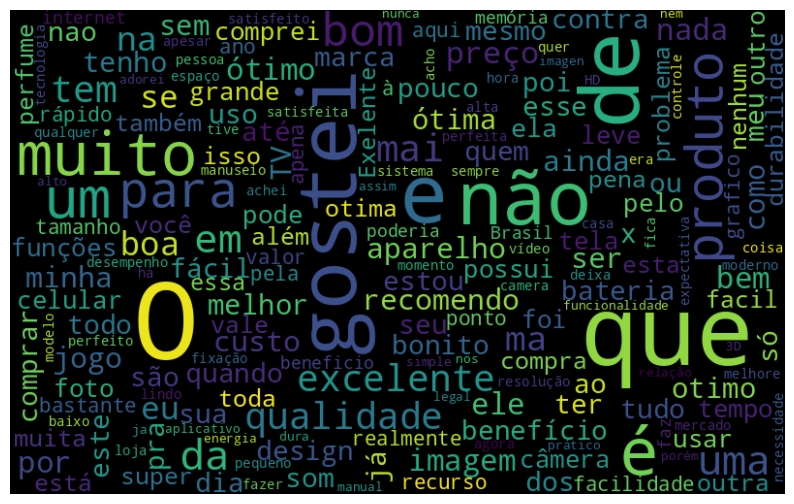

In [ ]:
generate_wordcloud(dataset.query("polarity_label == 'positive'"), "review_text")

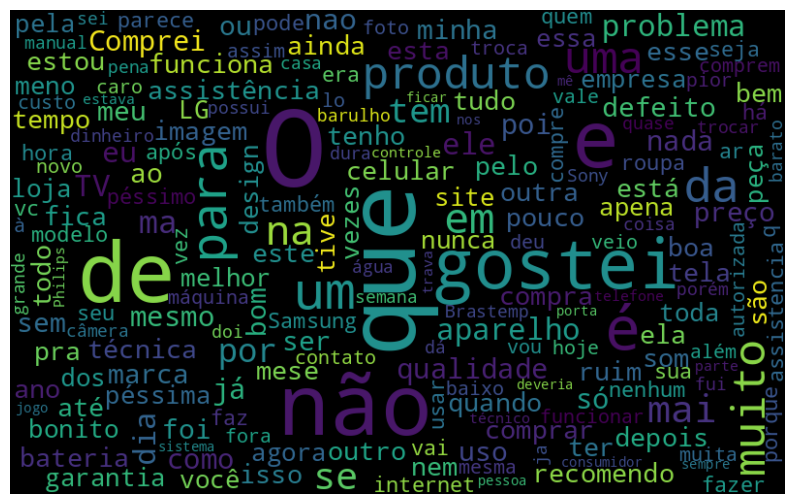

In [ ]:
generate_wordcloud(dataset.query("polarity_label == 'negative'"), "review_text")

## Tokenizing

In [ ]:
import nltk

def tokenizer(dataframe, text_column, lower = True):
    tokenizer = nltk.tokenize.WordPunctTokenizer()
    all_words = ' '.join([ text.lower() if lower else text for text in dataframe[text_column] ])
    return tokenizer.tokenize(all_words)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Word Frequency Graphics

In [ ]:
tokenized_data = tokenizer(dataset, "review_text")
frequency = nltk.FreqDist(tokenized_data)
frequency_df = pd.DataFrame({
    "word": list(frequency.keys()),
    "frequency": list(frequency.values())
})
frequency_df

,word,frequency
0,um,9729
1,carro,170
2,confortável,76
3,com,9766
4,bom,3921
...,...,...
28008,umbigo,1
28009,debilidade,1
28010,igualando,1
28011,pocket,1


In [ ]:
import seaborn as sns

def word_frequencies_graphic(tokenized_data, n_largest):
    frequency = nltk.FreqDist(tokenized_data)
    frequency_df = pd.DataFrame({
        "word": list(frequency.keys()),
        "frequency": list(frequency.values())
    })
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data = frequency_df.nlargest(columns = "frequency", n = n_largest),
        x = "word",
        y = "frequency"
    )
    plt.show()

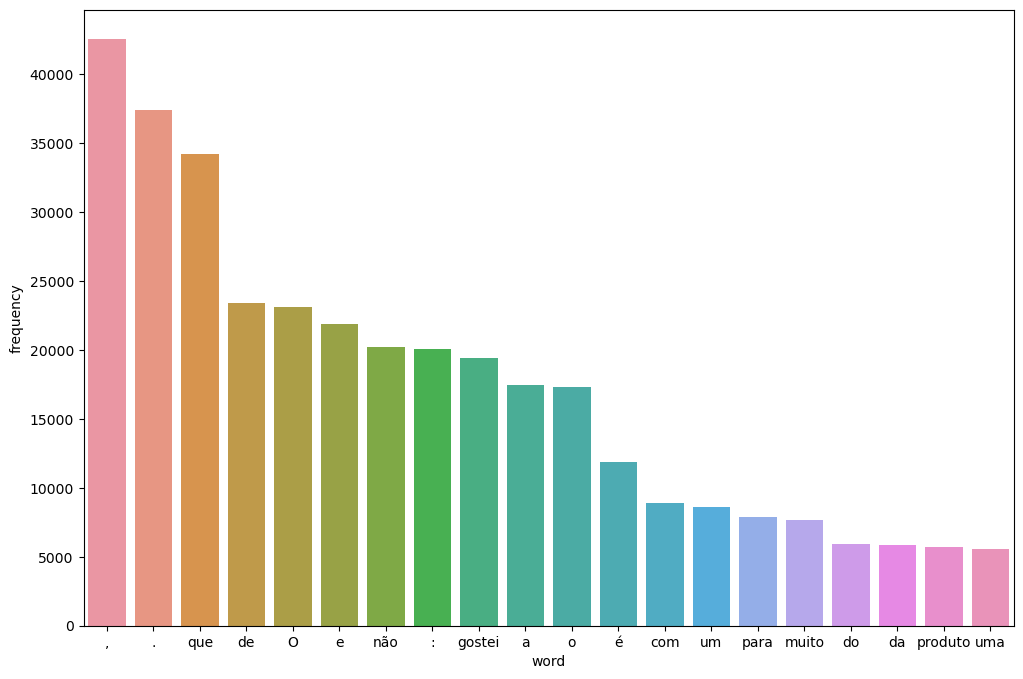

In [ ]:
tokenized_data = tokenizer(dataset, "review_text", False)
word_frequencies_graphic(tokenized_data, 20)

Based on word frequency graphic, I could **remove punctuations**, that is not so relevant to the context of this analysis, **and stop words** as 'de', 'e', 'o', 'a', etc...

# Data Treatment

## Treatment 1: Removing Stop Words, punctuation, accentuation and transform to lowercase

The basic treatment to any language consists in tranform to lower, removing punctuation and stop words in the most of cases. Working with languages as portuguese this basic treatment includes removing accentuation. I think that remove accentuation is very important to avoid inconsistent datas resulted from typos, for example, a common word present in product reviews are "ótimo" that could be writen as "otimo". Removing accentuation at the first treatment, avoid these kinds of ambiguous data.

In [ ]:
import string
import unidecode

puncts = [ punct for punct in string.punctuation ]
stopwords = list(set([ unidecode.unidecode(stopword) for stopword in nltk.corpus.stopwords.words("portuguese")]))
stopwords_puncts = sorted(stopwords + puncts)
print(stopwords_puncts)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'ate', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'eramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos', 'estao', 'estar', 'estas', 'estava', 'estavam', 'estavamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiveramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivessemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'foramos', 'forem', 'formos', 'fosse', 'fossem', 'fossemos', 'fui', 'ha', 'haja', 'hajam', 'hajamos', 'hao', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houveram', 'houveramos', 'houverao', 'houverei', 'houver

I choose to reduce stopwords list, using `set` to remove duplicates, because removing accentuation from data there are some repeated words.

In [ ]:
def remove_stopwords_accentuation_punctuation_lower(dataframe, text_column):
    word_punct_tokenizer = nltk.tokenize.WordPunctTokenizer()
    treated_text_data = []
    for review in dataframe[text_column]:
        tokenized_review = word_punct_tokenizer.tokenize(review)
        treated_review = []
        for word in tokenized_review:
            treated_word = unidecode.unidecode(word.lower())
            if treated_word not in stopwords_puncts:
                treated_review.append(treated_word)
        treated_text_data.append(' '.join(treated_review))
    dataset["treat_stopword_punct_accent_lower"] = treated_text_data

In [ ]:
remove_stopwords_accentuation_punctuation_lower(dataset, "review_text")

In [ ]:
dataset.head()

,review_text,polarity,rating,polarity_label,treat_stopword_punct_accent_lower
29181,Um carro confortável com bom acabamento e moto...,1.0,5,positive,carro confortavel bom acabamento motor bom ape...
12301,"Produto excelente, que reunião qualidade e amp...",1.0,4,positive,produto excelente reuniao qualidade ampla rede...
14740,Faz varios anos que eu migrei do PC pra Mac. A...,1.0,5,positive,faz varios anos migrei pc pra mac vantagem cas...
15234,Produto de primeira linha para armazenamento e...,1.0,5,positive,produto primeira linha armazenamento backup ar...
17920,"Adquiri o produto logo no lançamento, o valor ...",1.0,4,positive,adquiri produto logo lancamento valor produto ...


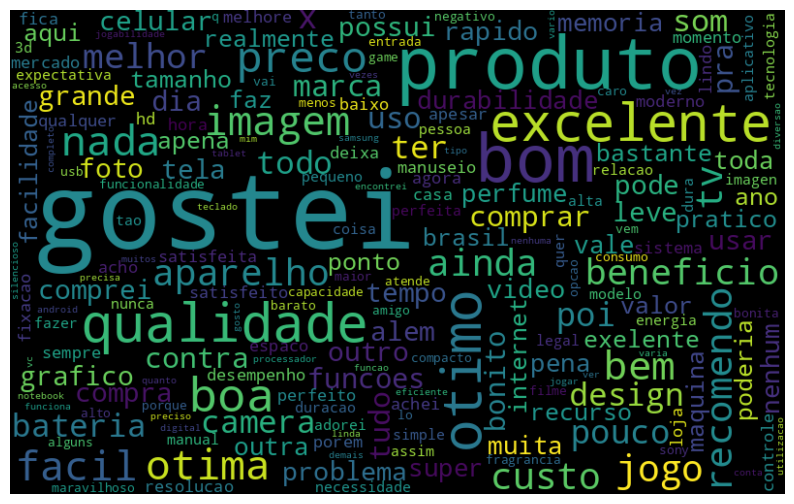

In [ ]:
generate_wordcloud(dataset.query("polarity_label == 'positive'"), "treat_stopword_punct_accent_lower")

Just removing stop words and punctuation, some **relevant words were highlighted in positive dataset as 'produto', 'excelente', 'bom', 'qualidade', 'recomendo', etc...**. I found some **highlighted typos** as 'execelent' instead of 'excelente' or 'apena' instead of 'apenas' or 'otimo' instead of 'ótimo'. **This kind of error could be fixed using stemming and accent treatments.**

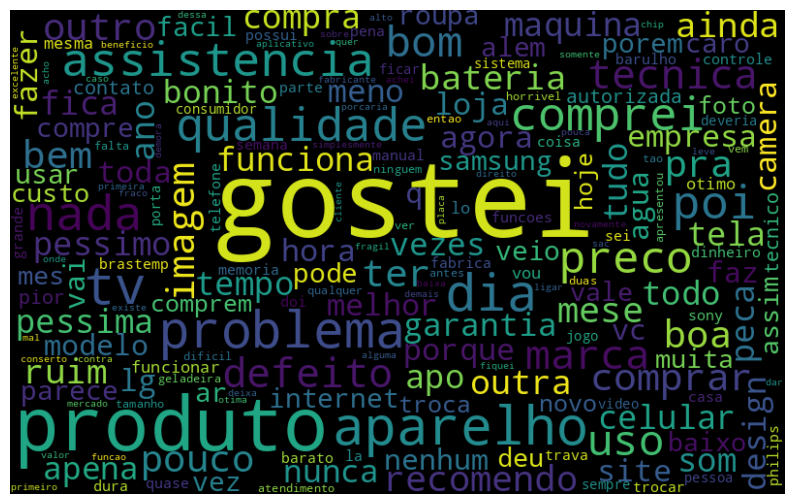

In [ ]:
generate_wordcloud(dataset.query("polarity_label == 'negative'"), "treat_stopword_punct_accent_lower")

The treatment with stopwords in negative dataset highlighted words as 'não', 'péssima', 'problema', 'péssimo', 'defeito', 'baixo, etc... However, I detected some problems to solve in next treatments, for example, **same words with different genders** and the **word 'gostei' also was highlighted as in positive dataset. It probably occurs because people use expressions like 'não gostei' to express negative fellings about the product**. To better explore this data, **I'm considering to use bi-grams.** There are some typos too, that could be solved using stemming.

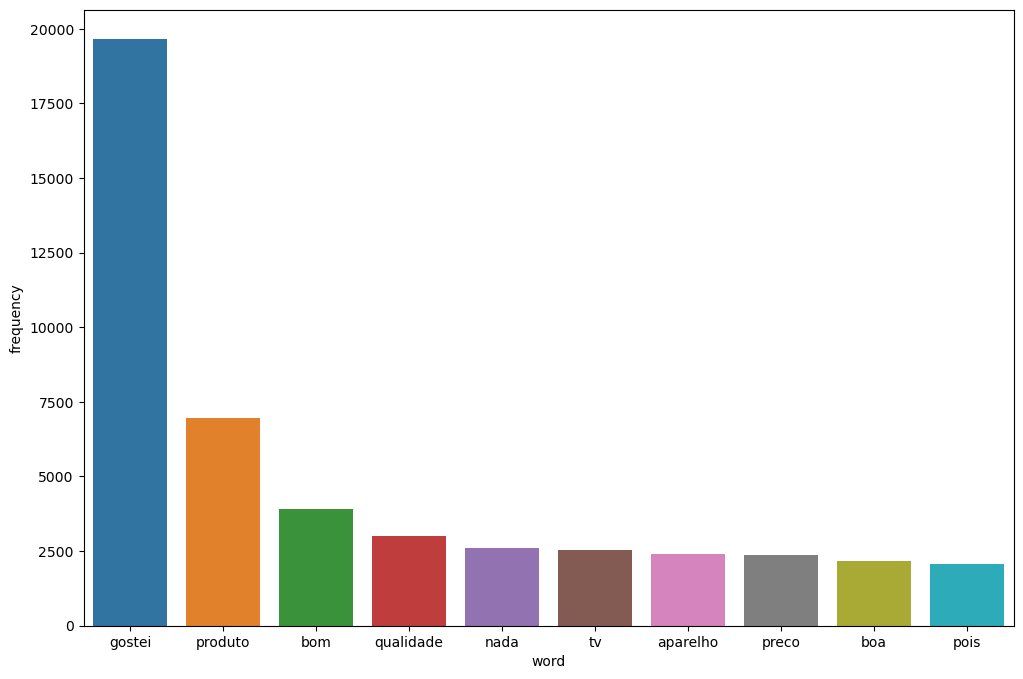

In [ ]:
tokenized_data = tokenizer(dataset, "treat_stopword_punct_accent_lower", False)
word_frequencies_graphic(tokenized_data, 10)

The most frequent words looks very informative to determine sentiments. However, as I said above, the massive quantity of word 'gostei' still probably associated with trully positive as 'gostei do produto' but also still related to negative as in 'não gostei do produto'. This hipothesis could be checked with n-grams, that I intend to apply in the future of this analysis.

## Treatment 2:  Stemming

Portuguese, as other languages, had a lot of variation of "same word" as verb conjugation, gender derivation, etc... It could generate ambiguous data, for example, 'ótimo' and 'ótima' are the same word semmantically but could be interpreted as different words from ML algorithms. Using stemming method we could reduce this ambiguous data extracting just the stem of these words. There is some Stemmer methos on package `nlpk` and `RSLPStemmer` is used to portuguese language.

In [ ]:
def stemmizer(dataframe: pd.DataFrame, text_column: str):
    whitespace_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    stemmer = nltk.RSLPStemmer()
    treated_data = []
    for review in dataframe[text_column]:
        tokenized_review = whitespace_tokenizer.tokenize(review)
        treated_review = []
        for word in tokenized_review:
            treated_review.append(stemmer.stem(word))
        treated_data.append(' '.join(treated_review))
    dataset["treat_stem"] = treated_data

In [ ]:
stemmizer(dataset, "treat_stopword_punct_accent_lower")

In [ ]:
dataset.head()

,review_text,polarity,rating,polarity_label,treat_stopword_punct_accent_lower,treat_stem
29181,Um carro confortável com bom acabamento e moto...,1.0,5,positive,carro confortavel bom acabamento motor bom ape...,carr conforta bom acab motor bom apes 1 6 pec ...
12301,"Produto excelente, que reunião qualidade e amp...",1.0,4,positive,produto excelente reuniao qualidade ampla rede...,produt excel reunia qual ampl red autor recom ...
14740,Faz varios anos que eu migrei do PC pra Mac. A...,1.0,5,positive,faz varios anos migrei pc pra mac vantagem cas...,faz vari ano migr pc pra mac vantag cas desenv...
15234,Produto de primeira linha para armazenamento e...,1.0,5,positive,produto primeira linha armazenamento backup ar...,produt prim linh armazen backup arqu recom
17920,"Adquiri o produto logo no lançamento, o valor ...",1.0,4,positive,adquiri produto logo lancamento valor produto ...,adquir produt log lanc val produt acim encontr...


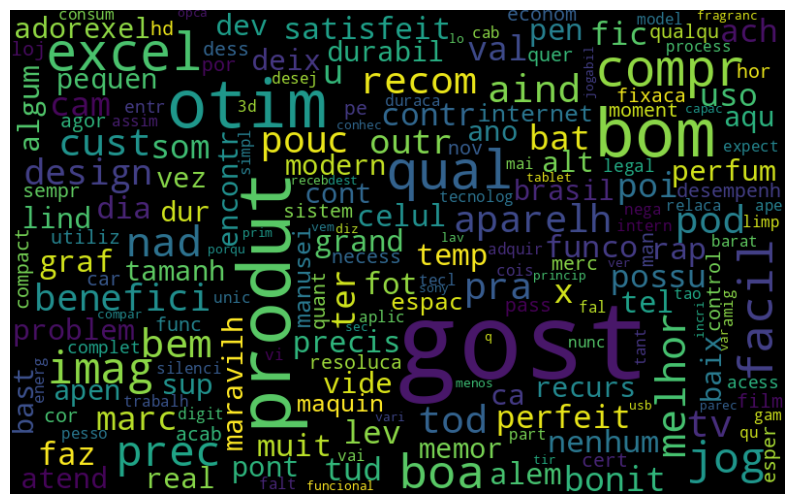

In [ ]:
generate_wordcloud(dataset.query("polarity_label == 'positive'"), "treat_stem")

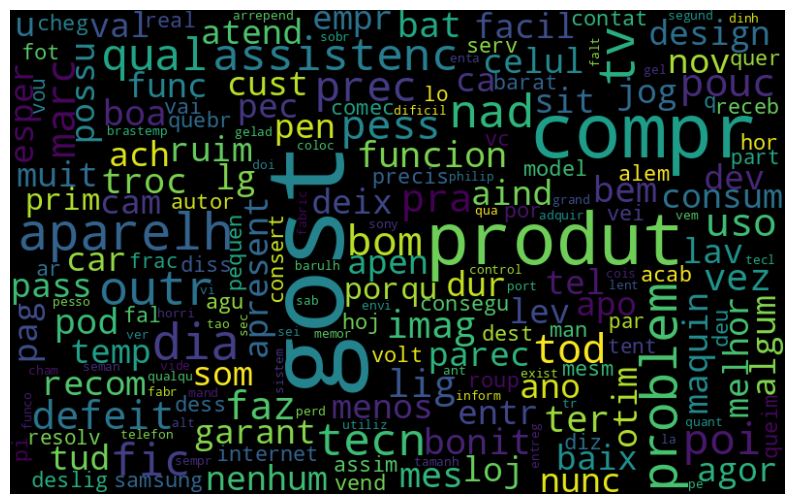

In [ ]:
generate_wordcloud(dataset.query("polarity_label == 'negative'"), "treat_stem")

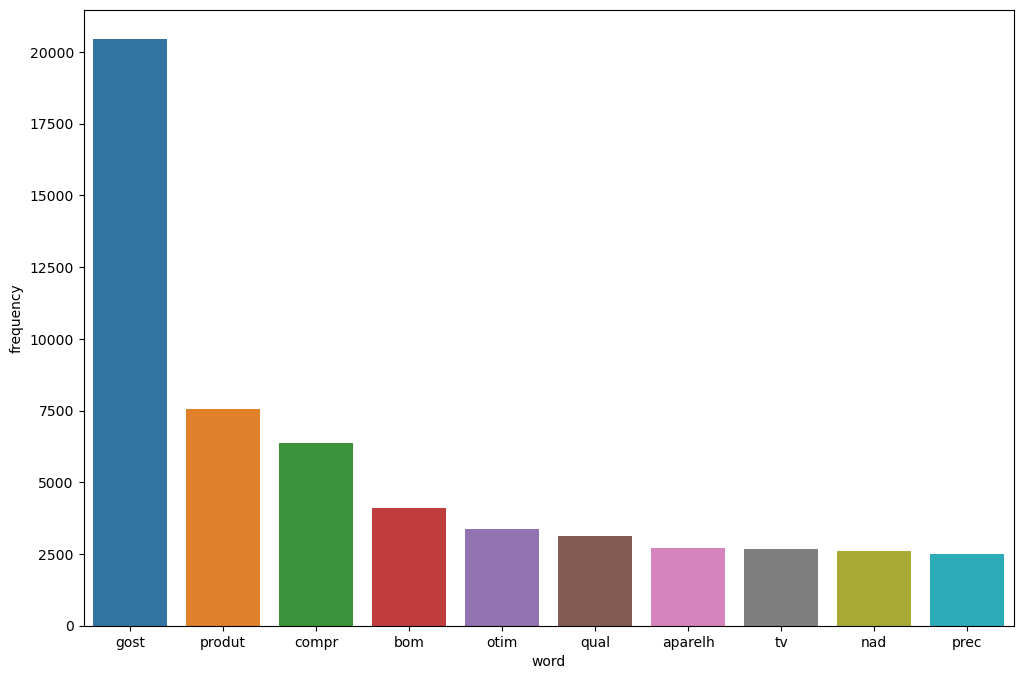

In [ ]:
tokenized_data = tokenizer(dataset, "treat_stem")
word_frequencies_graphic(tokenized_data, 10)

# First Data Analysis

## Bag of Words with CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(lowercase = False, max_features = 100)
bag_of_words = count_vectorizer.fit_transform(dataset["treat_stem"])

## Spliting Data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
    train_test_split(
        bag_of_words,
        dataset["polarity"],
        stratify = dataset["polarity"],
        shuffle = True,
        random_state = 42
    )

## Text classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

first_analysis = LogisticRegression()
first_analysis.fit(x_train, y_train)
accuracy = first_analysis.score(x_test, y_test)
print(f'First analysis using basic treatments and stemming reach an accuracy of: {accuracy}')

First analysis using basic treatments and stemming reach an accuracy of: 0.8046989720998532


**The first analysis reach an accuracy of 80% which is a good result**, however we could apply some treatments as **n-gram** and **TF-IDF** using `TfidfVectorizer` instead of `CountVectorizer`.

# Second Data Analysis

In this second data analysis, I'll try to apply `TF-IDF` to vectorize based on word frequency fixed in whole corpus.

## Bag of Words with TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase = False, max_features = 100)
bag_of_words = vectorizer.fit_transform(dataset["treat_stem"])

## Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
    train_test_split(bag_of_words, dataset["polarity"], random_state = 42)

## Text Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

second_analysis = LogisticRegression(solver = "lbfgs")
second_analysis.fit(x_train, y_train)
accuracy = second_analysis.score(x_test, y_test)
print(f'Second analysis using basic treatment, stemming and TF-IDF reach an accuracy of: {accuracy}')

Second analysis using basic treatment, stemming and TF-IDF reach an accuracy of: 0.7841409691629956


TF-IDF do not increase accuracy, it keep the same. I'm going to apply **n-grams**.

# Third Data Analysis

## Bag of Words with TfidfVectorizer and n-grams

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer_ngrams = TfidfVectorizer(lowercase = False, max_features = 100, ngram_range=(1,2))
bag_of_words = tfidf_vectorizer_ngrams.fit_transform(dataset["treat_stem"])

## Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
    train_test_split(
    bag_of_words,
    dataset["polarity"],
    train_size = 0.7,
    test_size = 0.3,
    stratify = dataset["polarity"],
    random_state = 42
    )

## Text Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

third_analysis = LogisticRegression(solver = "lbfgs")
third_analysis.fit(x_train, y_train)
accuracy = third_analysis.score(x_test, y_test)
print(f'Third analysis using basic treatment, stemming and TF-IDF reach an accuracy of: {accuracy}')

Third analysis using basic treatment, stemming and TF-IDF reach an accuracy of: 0.7936857562408223


**N-grams strategy do not increase accuracy of model.**

# Exporting model and dependencies

In [ ]:
import sklearn
import pickle
import wordcloud
import matplotlib

In [ ]:
sklearn.__version__

'1.2.2'

In [ ]:
nltk.__version__

'3.2.4'

In [ ]:
wordcloud.__version__

'1.9.2'

In [ ]:
matplotlib.__version__

'3.7.2'

In [ ]:
with open("/kaggle/working/requirements.txt", "w") as file:
    file.write(f"sklearn=={sklearn.__version__}\n")
    file.write(f"nltk=={nltk.__version__}\n")
    file.write(f"wordcloud=={wordcloud.__version__}\n")
    file.write(f"matplotlib=={matplotlib.__version__}\n")

In [ ]:
pickle.dump(third_analysis, open("/kaggle/working/model.sav", 'wb'))

In [ ]:
pickle.dump(tfidf_vectorizer_ngrams, open("/kaggle/working/vectorizer.sav", "wb"))